##  Exploratory Data Analysis (EDA)
'''
Here, working with the **Medical Insurance Dataset**, which contains demographic and health-related information about individuals, along with their corresponding medical insurance charges. Before building our preprocessing pipeline, it is essential to explore the data and understand relationships between variables.

This step helps:
- Identify skewness in numeric variables (like `charges`)
- Detect strong correlations (like between `smoker` and `charges`)
- Visualize group-wise trends (like `region` or `sex`)
- Spot outliers and variability in numeric features

EDA gives us insights that guide our transformation decisions in the later steps.
'''

In [1]:
import pandas as pd

# Load directly from GitHub
url = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"
df = pd.read_csv(url)

# Save locally (optional)
df.to_csv("insurance.csv", index=False)

# Display top rows
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [2]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

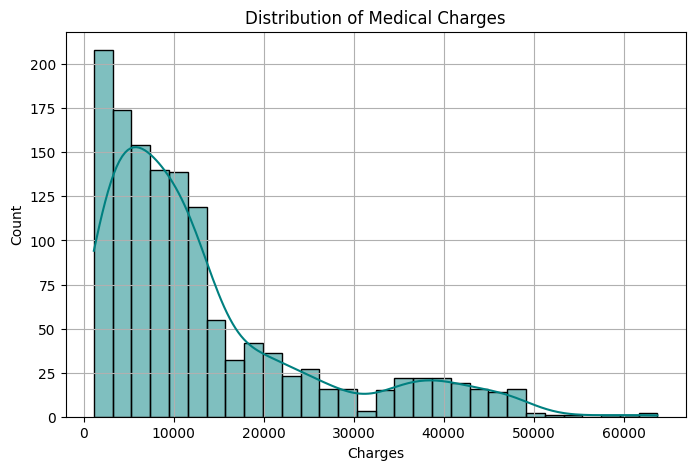

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df['charges'], kde=True, color='teal')
plt.title("Distribution of Medical Charges")
plt.xlabel("Charges")
plt.ylabel("Count")
plt.grid(True)
plt.show()

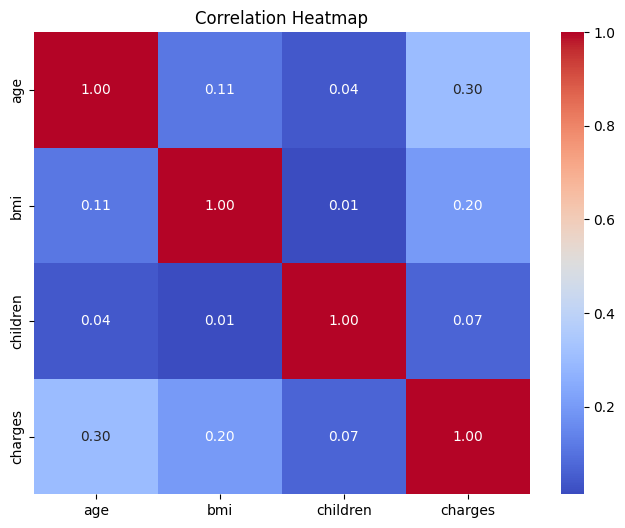

In [34]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.select_dtypes(include=['float64', 'int64']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


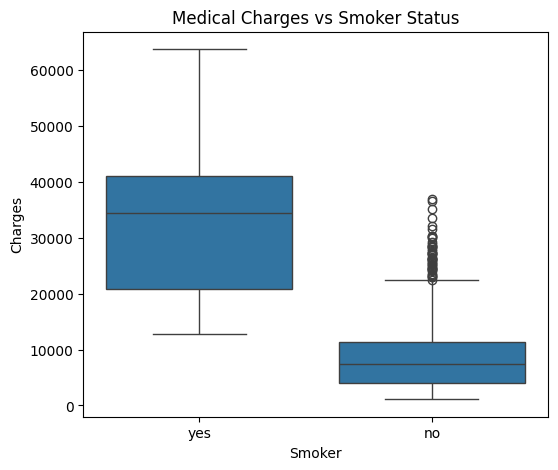

In [32]:
plt.figure(figsize=(6, 5))
sns.boxplot(x='smoker', y='charges', data=df)
plt.title("Medical Charges vs Smoker Status")
plt.xlabel("Smoker")
plt.ylabel("Charges")
plt.show()


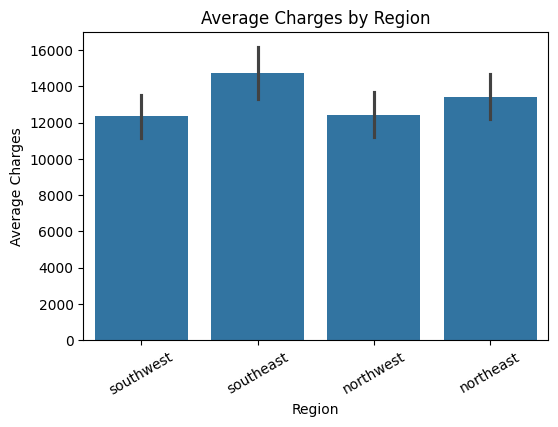

In [33]:
plt.figure(figsize=(6, 4))
sns.barplot(x='region', y='charges', data=df, estimator=np.mean)
plt.title("Average Charges by Region")
plt.ylabel("Average Charges")
plt.xlabel("Region")
plt.xticks(rotation=30)
plt.show()


In [5]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Identify column types
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

print("Numerical:", list(numerical_cols))
print("Categorical:", list(categorical_cols))

Numerical: ['age', 'bmi', 'children', 'charges']
Categorical: ['sex', 'smoker', 'region']


In [7]:
# Numeric preprocessing pipeline
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),        # Fill missing values with mean
    ('scaler', StandardScaler())                         # Standardize numeric features
])

In [8]:
# Categorical preprocessing pipeline
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),   # Fill missing with most frequent value
    ('encoder', OneHotEncoder(handle_unknown='ignore'))     # Convert text to numbers
])

In [9]:
# Combine both pipelines using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

In [10]:
print(preprocessor)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 Index(['age', 'bmi', 'children', 'charges'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['sex', 'smoker', 'region'], dtype='object'))])


In [17]:
# Separate input features (X) and target variable (y)
X = df.drop('charges', axis=1)  # All columns except target
y = df['charges']               # Target column

print("Shape of Features (X):", X.shape)
print("Shape of Target (y):", y.shape)

Shape of Features (X): (1338, 6)
Shape of Target (y): (1338,)


## 🔧 Step 6: Preprocessing Pipelines

We build two separate pipelines:
- One for numeric features (mean imputation + scaling)
- One for categorical features (mode imputation + one-hot encoding)
These are combined using `ColumnTransformer` to form a single preprocessor.

⚠️ NOTE:
We are redefining the preprocessing pipeline here after defining `X` and `y` (features and target),
because earlier the column list (`numerical_cols`) was taken from the full `df`, which still included 'charges'.

After we drop 'charges' from `X`, we need to re-identify columns again
so that the pipeline applies only to the columns that actually exist in `X`.

Otherwise, it throws an error saying: "A given column is not a column of the dataframe".

In [ ]:

# ✅ Re-identify columns based on updated X
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

#"Preprocessor rebuilt later after charges was dropped from features."

#Numeric pipeline
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine into full preprocessor (REBUILT here)
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

In [36]:
# Apply the full preprocessing pipeline to features
X_processed = preprocessor.fit_transform(X)

In [37]:
print("Shape after preprocessing:", X_processed.shape)

Shape after preprocessing: (1338, 11)


In [26]:
import numpy as np
import pandas as pd

# Convert to DataFrame if it's a sparse matrix
X_df = pd.DataFrame(X_processed.toarray() if hasattr(X_processed, 'toarray') else X_processed)

# Display first few rows
X_df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-1.438764,-0.453320,-0.908614,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-1.509965,0.509621,-0.078767,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-0.797954,0.383307,1.580926,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-0.441948,-1.305531,-0.908614,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,-0.513149,-0.292556,-0.908614,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [27]:
from sklearn.model_selection import train_test_split

# Split processed data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1070, 11)
X_test shape: (268, 11)
y_train shape: (1070,)
y_test shape: (268,)


In [28]:
# Save the train set to CSV
import numpy as np

np.savetxt("X_train.csv", X_train.toarray() if hasattr(X_train, 'toarray') else X_train, delimiter=",")
y_train.to_csv("y_train.csv", index=False)

In [29]:
import os

print("Files in current folder:")
print(os.listdir())

Files in current folder:
['.android', '.arduinoIDE', '.idlerc', '.ipynb_checkpoints', '.ipython', '.jupyter', '.matplotlib', '.vscode', '189313A_042024.pdf', '3D Objects', 'AppData', 'Application Data', 'Class 12', 'Contacts', 'Cookies', 'Data Analytics', 'Documents', 'Downloads', 'Favorites', 'insurance.csv', 'IntelGraphicsProfiles', 'Links', 'Local Settings', 'Microsoft', 'Music', 'My Documents', 'NetHood', 'NTUSER.DAT', 'ntuser.dat.LOG1', 'ntuser.dat.LOG2', 'NTUSER.DAT{2ad838bc-efea-11ee-a54d-000d3a94eaa1}.TM.blf', 'NTUSER.DAT{2ad838bc-efea-11ee-a54d-000d3a94eaa1}.TMContainer00000000000000000001.regtrans-ms', 'NTUSER.DAT{2ad838bc-efea-11ee-a54d-000d3a94eaa1}.TMContainer00000000000000000002.regtrans-ms', 'ntuser.ini', 'OneDrive', 'PrintHood', 'Project1_ETL_pipeline.ipynb', 'PycharmProjects', 'Recent', 'Saved Games', 'Searches', 'SendTo', 'Start Menu', 'Sti_Trace.log', 'Templates', 'Untitled.ipynb', 'Videos', 'X_train.csv', 'y_train.csv']
